<a href="https://colab.research.google.com/github/MahdiNouraie/RNN-and-Transformers/blob/main/DeepAR_MSFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
! pip install yfinance

In [5]:
import yfinance as yf

In [6]:
ms = yf.download('MSFT' ,
                            start = '2012-01-01',
                            end = '2021-12-31',
                            progress = False )
df = ms[['Adj Close' , 'Open' , 'Close' , 'High' , 'Low' ]].round(3)
df

,Adj Close,Open,Close,High,Low
Date,,,,,
2012-01-03,21.573,26.55,26.77,26.96,26.39
2012-01-04,22.081,26.82,27.40,27.47,26.78
2012-01-05,22.306,27.38,27.68,27.73,27.29
2012-01-06,22.653,27.53,28.11,28.19,27.53
2012-01-09,22.355,28.05,27.74,28.10,27.72
...,...,...,...,...,...
2021-12-23,333.223,332.75,334.69,336.39,332.73
2021-12-27,340.949,335.46,342.45,342.48,335.43
2021-12-28,339.755,343.15,341.25,343.81,340.32


In [ ]:
!pip install gluonts

In [2]:
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [ ]:
!pip install mxnet

In [15]:
import mxnet

In [7]:
train_data = ListDataset(
                [{'start' : df.index[0], 'target' : df.Close[:'2020']}],
                freq = 'D'
)

In [9]:
train_listData = next(iter(train_data))
train_series = to_pandas(train_listData)
train_series

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


2012-01-03     26.770000
2012-01-04     27.400000
2012-01-05     27.680000
2012-01-06     28.110001
2012-01-07     27.740000
                 ...    
2018-03-12    222.750000
2018-03-13    224.960007
2018-03-14    224.149994
2018-03-15    221.679993
2018-03-16    222.419998
Freq: D, Length: 2265, dtype: float32

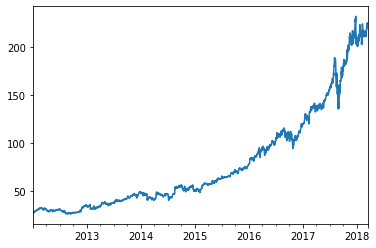

In [11]:
train_series.plot()

In [12]:
test_data = ListDataset(
                [{'start' : df.index[0], 'target' : df.Close}],
                freq = 'D'
)

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


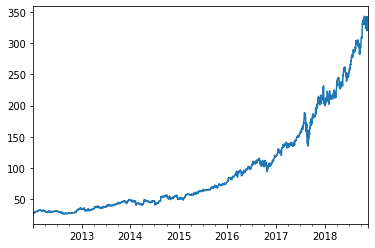

In [13]:
test_listData = next(iter(test_data))
test_series = to_pandas(test_listData)
test_series.plot()

In [25]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer.model_averaging import ModelAveraging,SelectNBestMean
from gluonts.mx.trainer import Trainer

In [24]:
callbacks = [
             LearningRateReduction(objective = 'min',
                                   patience = 10,
                                   base_lr = 1e-3,
                                   decay_factor = 0.5),
             ModelAveraging(avg_strategy = SelectNBestMean(num_models = 2) )
                ]

In [28]:
deepAR_model = DeepAREstimator(freq = 'D' , 
                            prediction_length = 5,
                            context_length = 10,
                            num_layers = 4,
                            num_cells = 100,
                            dropout_rate = 0.05,
                            cell_type = 'gru',
                            trainer = Trainer(epochs = 100 , callbacks = callbacks)
                            )

In [29]:
deepAR_model_predictor = deepAR_model.train(train_data)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed i

In [30]:
from gluonts.evaluation import make_evaluation_predictions

In [31]:
forcast_it, ts_it = make_evaluation_predictions(
    dataset = test_data,
    predictor = deepAR_model_predictor,
    num_samples = 100
)

In [ ]:
forecasts = list(forcast_it)
tss = list(ts_it)

In [35]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

array([26.77, 27.4 , 27.68, 28.11, 27.74], dtype=float32)

In [36]:
forecast_entry = forecasts[0]

In [38]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 5
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

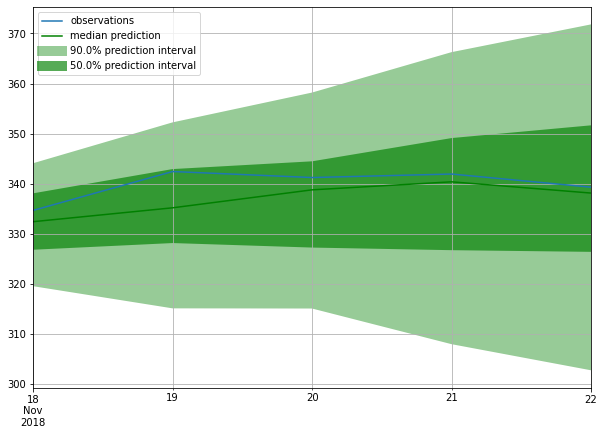

In [39]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [40]:
forecast_entry.samples.shape

(100, 5)

In [41]:
forecast_entry.mean

array([332.12732, 334.79785, 336.8216 , 337.47986, 337.21866],
      dtype=float32)

In [42]:
forecast_entry.quantile(0.7)

array([337.0347 , 342.20163, 342.4345 , 345.78183, 348.077  ],
      dtype=float32)